# Music Genre Classification

* Install Miniconda from their website
* Put Conda on PATH during the install
* Update conda - Terminal Command: conda update conda
* Clone the Github repository (send Tim or I your github username if you haven’t yet).
* Load environment.yaml into conda environment (this will take a while to download) - Terminal Command: conda env create -n mus2vid -f environment.yaml

## Download CSV file with Classical Dataset and Parse

In [40]:
import pandas as pd

classical_data = pd.read_csv('classical_dataset.csv')
# print (classical_data)

midis = list(classical_data['midi_filename'])
genres = list(classical_data['Genre'])
for i in range(0, len(midis)):
    midis[i] = "maestro-v3.0.0/" + midis[i]

genre_list = []
for i in genres:
    if not i in genre_list:
        genre_list.append(i)

print(midis)
print(genres)
print(genre_list)
print(len(midis))

['maestro-v3.0.0/2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R3_2018_wav--1.midi', 'maestro-v3.0.0/2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MID--AUDIO_03_R2_2008_wav--2.midi', 'maestro-v3.0.0/2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-split_07-07-17_Piano-e_3-02_wav--3.midi', 'maestro-v3.0.0/2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MID--AUDIO_21_R1_2004_01_Track01_wav.midi', 'maestro-v3.0.0/2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MID--AUDIO_17_R1_2006_04_Track04_wav.midi', 'maestro-v3.0.0/2009/MIDI-Unprocessed_07_R1_2009_04-05_ORIG_MID--AUDIO_07_R1_2009_07_R1_2009_04_WAV.midi', 'maestro-v3.0.0/2009/MIDI-Unprocessed_11_R1_2009_06-09_ORIG_MID--AUDIO_11_R1_2009_11_R1_2009_07_WAV.midi', 'maestro-v3.0.0/2013/ORIG-MIDI_03_7_8_13_Group__MID--AUDIO_19_R2_2013_wav--3.midi', 'maestro-v3.0.0/2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_04_WAV.midi', 'maestro-v3.0.0/2009/MIDI-Unprocessed_02_R1_2009_03-06_ORIG_MID--AUDIO_02_R1_2009_02_R1_2009_05_WAV.mid

## Process wav files and convert to MIDI objects


In [7]:
import pickle
import pretty_midi as pm
import pandas as pd
import numpy as np
import tensorflow as tf

def get_matched_midi(audio, genres):
    """
    Creates pretty-midi objects from input .wav files
    Matches each MIDI object with a composition year based on the years list

    Parameters:
        audio (list): list of audio filepaths.
        years (list): list of (approximate) composition years for each .wav file

    Returns:
        pandas.DataFrame: A DataFrame containing the pretty_midi obj and the corresponding composition year
    """
    prettys = [] # list of pretty_midi objects
    genre_ints = []
    iters = 0
    for i in range(len(audio)):
        print(iters)
        iters += 1

        midi_obj = pm.PrettyMIDI(audio[i])
        prettys.append(midi_obj)

        j = 0
        while (not(genres[i] == genre_list[j])):
            j += 1
        genre_ints.append(j)

    df = pd.DataFrame({'midi_obj': prettys, 'genre': genre_ints})

    return df

matched_midi_df = get_matched_midi(midis, genres)

# Optionally save the matched_midi_df DataFrame as a pickle file
with open("matched_midi.pkl", "wb") as f:
    pickle.dump(matched_midi_df, f)

# Print the first few rows
print(matched_midi_df.head())


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [1]:
import pickle

# If saved, load matched_midi_df from the saved pickle file
with open('matched_midi.pkl', 'rb') as f:
    matched_midi_df = pickle.load(f)
print(matched_midi_df.head())


                                            midi_obj  genre
0  <pretty_midi.pretty_midi.PrettyMIDI object at ...      0
1  <pretty_midi.pretty_midi.PrettyMIDI object at ...      0
2  <pretty_midi.pretty_midi.PrettyMIDI object at ...      0
3  <pretty_midi.pretty_midi.PrettyMIDI object at ...      1
4  <pretty_midi.pretty_midi.PrettyMIDI object at ...      1


## Extract Midi Files Features

In [56]:
import pickle
import numpy as np
import pretty_midi
from sklearn.utils import resample
from chord_detection.chord_detection_pyfile import *

def normalize_features(features):
    """
    Normalizes the features to the range [-1, 1].

    Parameters:
        features (list of float): The array of features.

    Returns:
        list of float: Normalized features.
    """
    # Normalize each feature based on its specific range
    tempo = (features[0] - 150) / 300
    num_sig_changes = (features[1] - 2) / 10
    resolution = (features[2] - 260) / 400
    time_sig_1 = (features[3] - 3) / 8
    time_sig_2 = (features[4] - 3) / 8
    melody_complexity = (features[5] - 0) / 10
    melody_range = (features[6] - 0) / 80

    # Normalize pitch class histogram
    pitch_class_hist = [((f - 0) / 100) for f in features[7:-1]]

    # Return the normalized feature vector
    return [tempo, num_sig_changes, resolution, time_sig_1, time_sig_2, melody_complexity, melody_range] + pitch_class_hist

def get_features(midi_obj):
    """
    Extracts specific features from a PrettyMIDI object given its path using the pretty_midi library.
    Handle any potential errors with MIDI files appropriately.

    Parameters:
        midi_obj: the PrettyMIDI object

    Returns:
        list of float: The extracted features.
    """
    
    # tempo: the estimated tempo of the audio file
    tempo = midi_obj.estimate_tempo()

    # num_sig_changes: the number of time signature changes in the audio file
    num_sig_changes = len(midi_obj.time_signature_changes)

    # resolution: the time resolution of the audio file (in ticks per beat)
    resolution = midi_obj.resolution


    # Extract time signature information
    ts_changes = midi_obj.time_signature_changes
    ts_1, ts_2 = 4, 4
    if len(ts_changes) > 0:
        ts_1 = ts_changes[0].numerator
        ts_2 = ts_changes[0].denominator
    
    # Extract melody-related features
    # melody: a pitch class histogram of the audio file
    melody = midi_obj.get_pitch_class_histogram()
    # melody_complexity: the number of unique pitch classes in the melody
    melody_complexity = np.sum(melody > 0)
    # melody_range: the range of pitch classes in the melody
    melody_range = np.max(melody) - np.min(melody)
    # OPTIONAL feature melody_contour: the temporal evolution of pitch content in the audio file
    # melody_contour = librosa.feature.tempogram(y=file.fluidsynth(fs=16000), sr=16000, hop_length=512)
    # melody_contour = np.mean(melody_contour, axis=0)
    # chroma: a chroma representation of the audio file
    chroma = midi_obj.get_chroma()
    # pitch_class_hist: the sum of the chroma matrix along the pitch axis
    pitch_class_hist = np.sum(chroma, axis=1)
    # Chord detection functions
    # chords = calculate_song_chords(midi_obj)
    # changes = chord_changes(chords, midi_obj)
    # grams = n_grams(chords, 3)

    features = normalize_features([tempo, num_sig_changes, resolution, ts_1,
                            ts_2, melody_complexity, melody_range] + list(pitch_class_hist))
    # features.append(chords)
    # features.append(changes)
    # features.append(grams)

    return features

def extract_midi_features(midi_df):
    """
    Extracts features and labels from MIDI objects listed in the DataFrame and concatenates the
    features with their labels into a matrix.

    Since the dataset is inherently unbalanced in terms of genre distribution, oversampling and 
    undersampling can be used to achieve a more balanced representation of features for each genre.

    Parameters:
        path_df (pandas.DataFrame): A DataFrame with pretty-midi objects and their composition years.

    Returns:
        numpy.ndarray: A matrix of features along with labels.
    """
    all_features = []  # List to store all extracted features
    iters = 0
    for index, row in midi_df.iterrows():
        print(iters)
        iters += 1
        obj_features = get_features(row['midi_obj'])
        obj_features.append(row['genre'])
        all_features.append(obj_features)
    # Return the numpy array of all extracted features along with corresponding years
    return np.array(all_features)

def balance_data(midi_df, genre_list):
    # Calculate the number of music samples in the genre with the most samples
    genre_balance = np.zeros(len(genre_list))
    for index, row in midi_df.iterrows():
        genre_balance[row['genre']] += 1
    max_samples = int(max(genre_balance))

    # resample other genres to have that many samples
    df_list = []
    for genre_num in range(len(genre_list)):
        df_list.append(midi_df[midi_df['genre'] == genre_num])

    balanced_list = []
    for df in df_list:
        if (len(df) != max_samples):
            df = resample(df, random_state=42, n_samples=max_samples, replace=True)
        balanced_list.append(df)

    balanced_df = pd.concat(balanced_list)

    return balanced_df

# Balance the input data
# balanced_df = balance_data(matched_midi_df, genre_list)

# Call the extract_midi_features function with the appropriate path DataFrame to extract the MIDI 
# file features and obtain the feature-label matrix
labeled_features = extract_midi_features(matched_midi_df)
# Print the labeled features
print(labeled_features)
print(labeled_features.shape)

# Optionally store the feature-label matrix as a pickle file for further use
with open('labeled_features_chords.pkl', 'wb') as f:
    pickle.dump(labeled_features, f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [6]:
import pickle

# If saved, load matched_midi_df from the saved pickle file
with open('labeled_features_classical.pkl', 'rb') as f:
    labeled_features = pickle.load(f)

print(labeled_features.shape)
print(labeled_features)

(2648, 19)
[[ 2.31951394e-01 -1.00000000e-01  5.50000000e-01 ...  6.78272000e+03
   5.61390000e+02  0.00000000e+00]
 [ 8.23696682e-02 -1.00000000e-01  5.50000000e-01 ...  3.99099000e+03
   2.49362300e+04  0.00000000e+00]
 [ 2.26865993e-01 -1.00000000e-01  3.10000000e-01 ...  1.53674000e+03
   1.32467000e+04  0.00000000e+00]
 ...
 [ 3.26929616e-01 -1.00000000e-01  3.10000000e-01 ...  1.93394000e+03
   5.06000000e+01  3.00000000e+00]
 [ 1.74022066e-01 -1.00000000e-01  5.50000000e-01 ...  2.69480000e+02
   3.75054000e+03  3.00000000e+00]
 [ 2.10494363e-01 -1.00000000e-01  3.10000000e-01 ...  4.04865000e+03
   1.87386000e+03  3.00000000e+00]]


## Partition Dataset into Training, Validation, and Testing

In [77]:
from keras.utils import to_categorical
import numpy as np
import pandas as pd

def balance_data(data_array, genres = genre_list):
    # create a data frame with the last column titled genre
    name_list = ['data'] * (data_array.shape[1] - 1)
    name_list.append('genre')
    data_df = pd.DataFrame(data_array)
    data_df.columns = name_list
    
    genre_balance = np.zeros(len(genres))
    for index, row in data_df.iterrows():
        genre_balance[int(row['genre'])] += 1
    max_samples = int(max(genre_balance))

    # resample other genres to have that many samples
    df_list = []
    for genre_num in range(len(genres)):
        df_list.append(data_df[data_df['genre'] == genre_num])

    balanced_list = []
    for df in df_list:
        if (len(df) != max_samples):
            df = resample(df, random_state=42, n_samples=max_samples, replace=True)
        balanced_list.append(df)

    balanced_df = pd.concat(balanced_list)
    balanced_array = balanced_df.to_numpy()
    
    return balanced_array

# Shuffle the features
labeled_features = np.random.permutation(labeled_features)

# Partition the Dataset into 3 Sets: Training, Validation, and Test
num = len(labeled_features)
# Calculate the number of samples for training data (60% of the dataset)
num_training = int(num * 0.6)
# Calculate the number of samples for validation data (20% of the dataset)
num_validation = int(num * 0.8)

# Extract the training data (60% of the labeled features)
training_data = balance_data(labeled_features[:num_training])
# Extract the validation data (20% of the labeled features)
validation_data = balance_data(labeled_features[num_training:num_validation])
# Extract the test data (remaining 20% of the labeled features)
test_data = (labeled_features[num_validation:])

# Separate the features from the labels
num_cols = training_data.shape[1] - 1
# Extract features from the training data
training_features = training_data[:, :num_cols]
# Extract features from the validation data
validation_features = validation_data[:, :num_cols]
# Extract features from the test data
test_features = test_data[:, :num_cols]

# Format the features for this multi-class classification problem
num_classes = len(genre_list)
# Extract years from the training data
training_labels = training_data[:, num_cols].astype(int)
# Extract years from the validation data
validation_labels = validation_data[:, num_cols].astype(int)
# Extract years from the test data
test_labels = test_data[:, num_cols].astype(int)

print(test_labels)  # Print the first 10 test labels
print(to_categorical((test_labels)))  # Print the one-hot encoding of the first 10 test labels

[2 1 2 2 1 2 2 2 2 2 2 2 3 2 3 3 3 2 2 2 1 1 1 2 3 2 1 1 2 2 3 2 1 2 2 3 2
 2 1 2 1 2 2 3 2 2 2 2 1 0 2 2 1 1 0 2 1 2 2 1 1 1 1 2 1 2 1 2 2 1 1 1 3 1
 2 1 1 2 3 2 2 2 2 2 2 2 2 1 2 2 2 3 2 1 1 2 3 2 2 1 3 1 1 2 2 1 2 0 0 3 3
 2 1 2 2 2 2 3 1 2 2 1 3 2 3 2 3 2 2 1 3 1 3 2 2 1 2 3 2 1 2 3 1 1 1 0 3 2
 0 1 1 2 2 3 3 2 2 2 3 3 3 2 1 3 2 1 3 3 1 1 2 3 2 2 2 0 2 2 3 2 2 2 2 2 3
 2 1 1 2 2 2 1 2 1 2 2 2 0 2 2 1 2 1 1 1 3 2 1 2 1 1 2 2 1 1 3 3 2 0 1 3 2
 2 3 2 2 3 3 2 2 2 3 2 3 2 1 0 3 1 1 1 3 2 1 2 0 1 2 1 2 1 1 1 3 0 2]
[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 ...
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


Epoch 1/200
167/167 - 1s - loss: 1.2485 - accuracy: 0.4143 - val_loss: 1.2866 - val_accuracy: 0.3946 - 1s/epoch - 7ms/step
Epoch 2/200
167/167 - 0s - loss: 1.1855 - accuracy: 0.4508 - val_loss: 1.2755 - val_accuracy: 0.4153 - 267ms/epoch - 2ms/step
Epoch 3/200
167/167 - 0s - loss: 1.1433 - accuracy: 0.5096 - val_loss: 1.3255 - val_accuracy: 0.4236 - 207ms/epoch - 1ms/step
Epoch 4/200
167/167 - 0s - loss: 1.1201 - accuracy: 0.5246 - val_loss: 1.2888 - val_accuracy: 0.4814 - 202ms/epoch - 1ms/step
Epoch 5/200
167/167 - 0s - loss: 1.0883 - accuracy: 0.5522 - val_loss: 1.3160 - val_accuracy: 0.4277 - 200ms/epoch - 1ms/step
Epoch 6/200
167/167 - 0s - loss: 1.0561 - accuracy: 0.5624 - val_loss: 1.3027 - val_accuracy: 0.4442 - 228ms/epoch - 1ms/step
Epoch 7/200
167/167 - 0s - loss: 1.0461 - accuracy: 0.5510 - val_loss: 1.2436 - val_accuracy: 0.4752 - 205ms/epoch - 1ms/step
Epoch 8/200
167/167 - 0s - loss: 1.0332 - accuracy: 0.5731 - val_loss: 1.3223 - val_accuracy: 0.4959 - 183ms/epoch - 1ms/

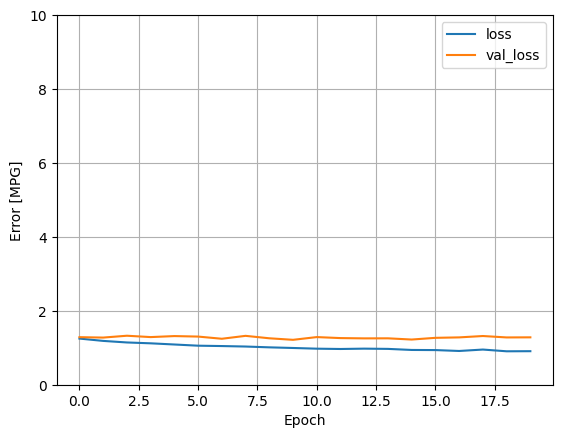

8/8 [==============================] - 0s 786us/step
Label:      2
Prediction: 2
Label:      1
Prediction: 0
Label:      2
Prediction: 2
Label:      2
Prediction: 2
Label:      1
Prediction: 2
Label:      2
Prediction: 2
Label:      2
Prediction: 3
Label:      2
Prediction: 3
Label:      2
Prediction: 2
Label:      2
Prediction: 2
Label:      2
Prediction: 1
Label:      2
Prediction: 2
Label:      3
Prediction: 3
Label:      2
Prediction: 2
Label:      3
Prediction: 2
Label:      3
Prediction: 3
Label:      3
Prediction: 3
Label:      2
Prediction: 2
Label:      2
Prediction: 0
Label:      2
Prediction: 2
Label:      1
Prediction: 2
Label:      1
Prediction: 3
Label:      1
Prediction: 2
Label:      2
Prediction: 2
Label:      3
Prediction: 3
Label:      2
Prediction: 2
Label:      1
Prediction: 0
Label:      1
Prediction: 2
Label:      2
Prediction: 2
Label:      2
Prediction: 2
Label:      3
Prediction: 3
Label:      2
Prediction: 2
Label:      1
Prediction: 1
Label:      2
Predictio

In [78]:
from tensorflow import keras
from keras import metrics
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import pretty_midi as pm


# Define the model architecture
normalizer = keras.layers.BatchNormalization()
model = keras.Sequential([
    normalizer,
    keras.layers.Dense(19, activation='relu'), # There are 17 variables in the feature matrix
    keras.layers.Dense(14, activation='relu'), # 2/3 the input layer + 1
    keras.layers.Dense(num_classes, activation='softmax')
])

"""
optimizer="adam": The optimizer algorithm to use during training. 
Adam optimizer is chosen, which is a popular optimization algorithm known for its efficiency.

loss='categorical_crossentropy': The loss function used to measure the discrepancy between the 
predicted output and the true output labels. Categorical cross-entropy is suitable for
multi-class classification tasks.

metrics=['accuracy']: The metric(s) to be evaluated during training and testing. 
Accuracy is a commonly used metric to assess the model's performance.
"""

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

"""
training_features, train_labels: Input features and corresponding labels for model training.

validation_features, val_labels: Validation set used to monitor the model's performance 
                                         during training.

batch_size=32: Number of samples per gradient update. Training data is divided into batches, 
               and the model's weights are updated after each batch.

epochs=50: Number of times the model will iterate over the entire training dataset.

callbacks: EarlyStopping to stop training if the validation loss does not improve for a certain 
           number of epochs, and ModelCheckpoint to save the best model based on validation loss.
"""

# Encode the training and validation labels using one-hot encoding
train_labels_encoded = to_categorical(training_labels)
val_labels_encoded = to_categorical(validation_labels)

history = model.fit(x=training_features, y=train_labels_encoded, 
                    validation_data=(validation_features, val_labels_encoded),
                    batch_size=10, epochs=200, verbose=2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10),
                               keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)])

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Error [MPG]')
plt.legend()
plt.grid(True)
plt.show()
# Save the entire model to an h5 file
model.save("my_model.h5")

# Use the loaded model for prediction
real_labels = [0,0,0,0]
predicted_labels = [0,0,0,0]
correct = [0,0,0,0]

preds = model.predict(test_features)

for i in range(len(test_labels)):
    real = test_labels[i]
    prediction = np.argmax(preds[i])
    real_labels[real] += 1
    predicted_labels[prediction] += 1

    print("Label:      " + str(real))
    print("Prediction: " + str(prediction))

    if (real == prediction):
        correct[real] += 1

print("Total labels in test data: ", real_labels)
print("Total labels in pred data: ", predicted_labels)
print("correct labels in test data: ", correct)
probabilities = [i / j for i, j in zip(correct, predicted_labels)]
print("prediction probabilities: ", probabilities)
    
danube_midi = pm.PrettyMIDI('The-Blue-Danube-Waltz.mid')
danube_feats = get_features(danube_midi)
danube_feats = np.asarray(danube_feats)
danube_feats = np.expand_dims(danube_feats, axis = 0)
print('danube: ', np.argmax(model.predict(danube_feats)))
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_features, to_categorical(test_labels))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
from tensorflow import keras
from keras import metrics
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import pretty_midi as pm
import torch.nn as nn

class Network(nn.Module):
    def __init__(self, num_features):
        super(Network, self).__init__()
        self.layer1 = nn.Linear(num_features, 42)
        self.layer2 = nn.Linear(42, 16)
        self.layer3 = nn.Linear(16, 4)